In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.quantum_info import SparsePauliOp, entanglement_of_formation, DensityMatrix

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from scipy.optimize import minimize


import numpy as np
import matplotlib.pyplot as plt


from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties

from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import Estimator
from qiskit_aer.primitives import EstimatorV2 as EstimatorAer
from qiskit_aer import AerSimulator


from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2,
    SamplerV2 as Sampler,
    EstimatorOptions
)


from qiskit.visualization import plot_distribution


from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.transformers import FreezeCoreTransformer, ActiveSpaceTransformer



from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint

#from numba import njit, jit

from entanglement_measures import GHZ_entanglmenetlike_measure, Multipartite_Negativity, multipartite_entanglement

In [2]:

#@jit
def initialize_HF_vqe_chemical(intermolecular_distance= 1, mapper= JordanWignerMapper(), basis = 'ccpvdz'):
    
    driver = PySCFDriver(atom=f"F 0 0 0; H 0 0 {intermolecular_distance}", basis=basis)
    full_problem = driver.run()

    act_space_tf = ActiveSpaceTransformer(num_electrons= 2, num_spatial_orbitals= 2)

    problem = act_space_tf.transform(full_problem)

    mapper = ParityMapper(num_particles=(problem.num_alpha, problem.num_beta))

    

    pauli_hamiltonian = mapper.map(problem.hamiltonian.second_q_op())


    #then we generate the Ansatz
    init_state = HartreeFock(problem.num_spatial_orbitals,
                         problem.num_particles,
                         mapper)

    ansatz = UCCSD(problem.num_spatial_orbitals,
               problem.num_particles,
               mapper,
               initial_state= init_state)
    
    return ansatz, pauli_hamiltonian, problem


#@jit
def vqe_chemical_ansatz(estimator, ansatz, problem, mapper=JordanWignerMapper(), optimizer= SLSQP()):
    vqe = VQE(estimator= estimator,
              ansatz= ansatz,
              optimizer= optimizer)

    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem

    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe)

    result = solver.solve(problem)

    gs_energy = result.total_energies[0]
    utilized_ansatz = result.groundstate[0]
    optimized_parameters = result.groundstate[1]

    optimal_ansatz = utilized_ansatz.assign_parameters(optimized_parameters)

    return gs_energy, optimal_ansatz



#@jit
def run_calculation_for_HF_gs(swept_interval, estimator):

    distances = swept_interval

    num_calc = len( swept_interval )

    entanglement_list_max = np.zeros(num_calc)
    entanglement_list_total = np.zeros(num_calc)

    negativity_list_max = np.zeros(num_calc)
    negativity_list_total = np.zeros(num_calc)

    ghz_measure_list = np.zeros(num_calc)

    energiesH2_list = np.zeros(num_calc)


    
    for i, d in enumerate(swept_interval):

        ansatz_h2, pauli_ham_h2, prob = initialize_HF_vqe_chemical(intermolecular_distance= d)

        gs_energy_d, optimal_ansatz_d = vqe_chemical_ansatz(estimator=estimator,
                                                            ansatz= ansatz_h2,
                                                            problem= prob)
        

        r = DensityMatrix(optimal_ansatz_d)

    

        energiesH2_list[i] = gs_energy_d

        entanglement_list_max[i] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'max' )
        entanglement_list_total[i] = multipartite_entanglement(optimal_ansatz_d, rho= r, mode= 'total')
        
        """
        negativity_list_max[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'max')
        negativity_list_total[i] = Multipartite_Negativity(circuit= optimal_ansatz_d, mode= 'total')
        """
        ghz_measure_list[i] = GHZ_entanglmenetlike_measure(optimal_ansatz_d)

    return energiesH2_list, entanglement_list_max, entanglement_list_total, negativity_list_max, negativity_list_total, ghz_measure_list

In [3]:
distances = np.arange(0.5, 2, 0.05)

estimator = Estimator()


energies_HF, entgmax_HF, entgtotal_HF, negmax_HF, negtotal_HF, ghzmeasure_HF = run_calculation_for_HF_gs(swept_interval= distances, estimator= estimator)

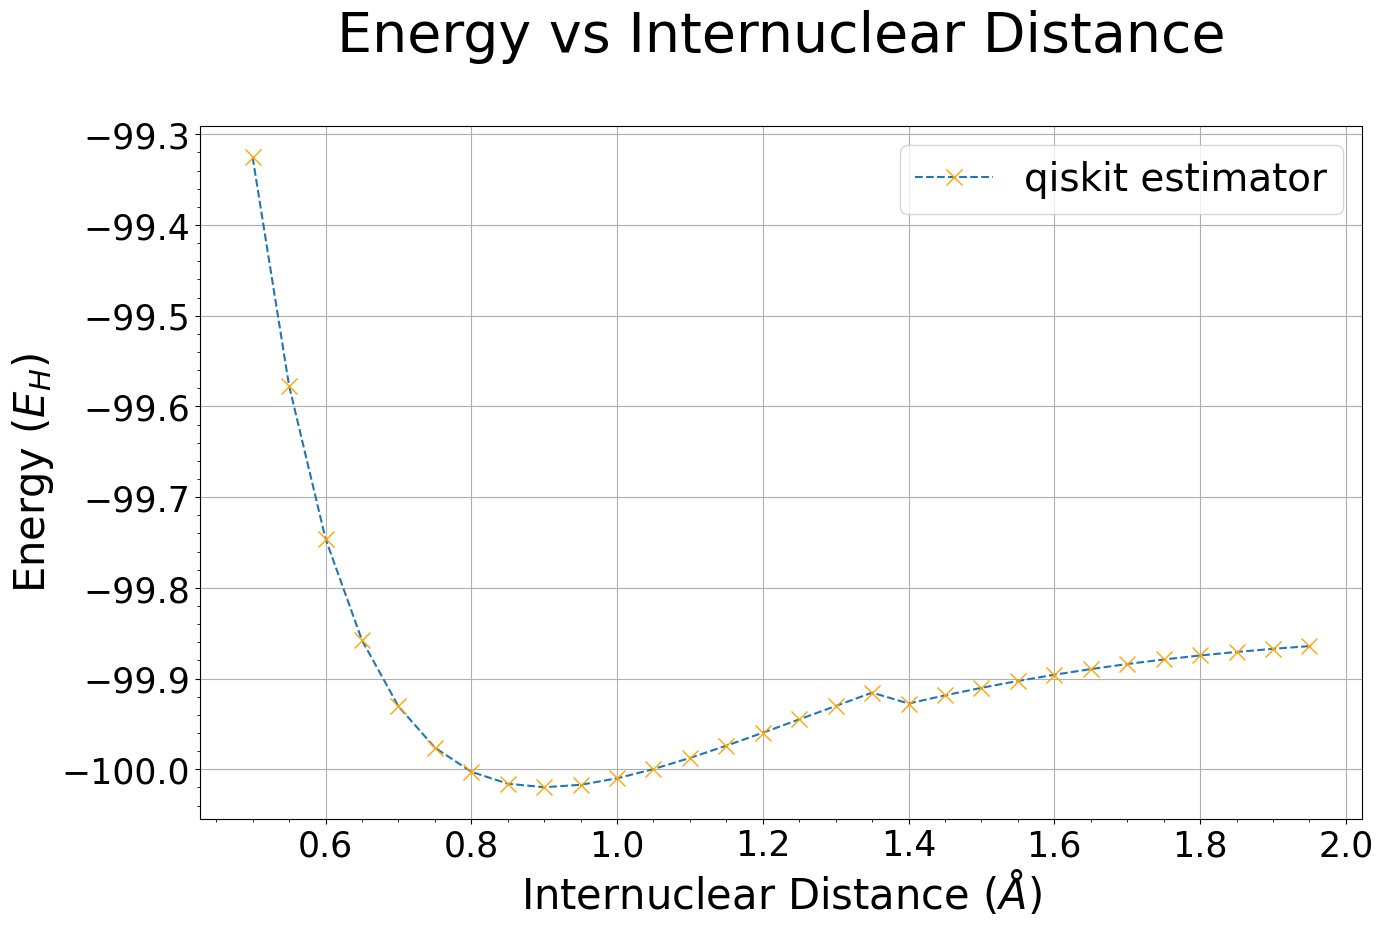

In [4]:
# Plotting the data
distances = np.arange(0.5, 2, 0.05)


plt.figure(figsize=(15, 9))
plt.plot(distances, energies_HF, marker='x', linestyle='--', label= 'qiskit estimator', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 12)
plt.xlabel('Internuclear Distance ($\AA$)', fontsize= 30 )
plt.ylabel('Energy ($E_H$)', fontsize= 30)
plt.title('Energy vs Internuclear Distance\n', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)
plt.minorticks_on()  # Enable minor ticks


plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

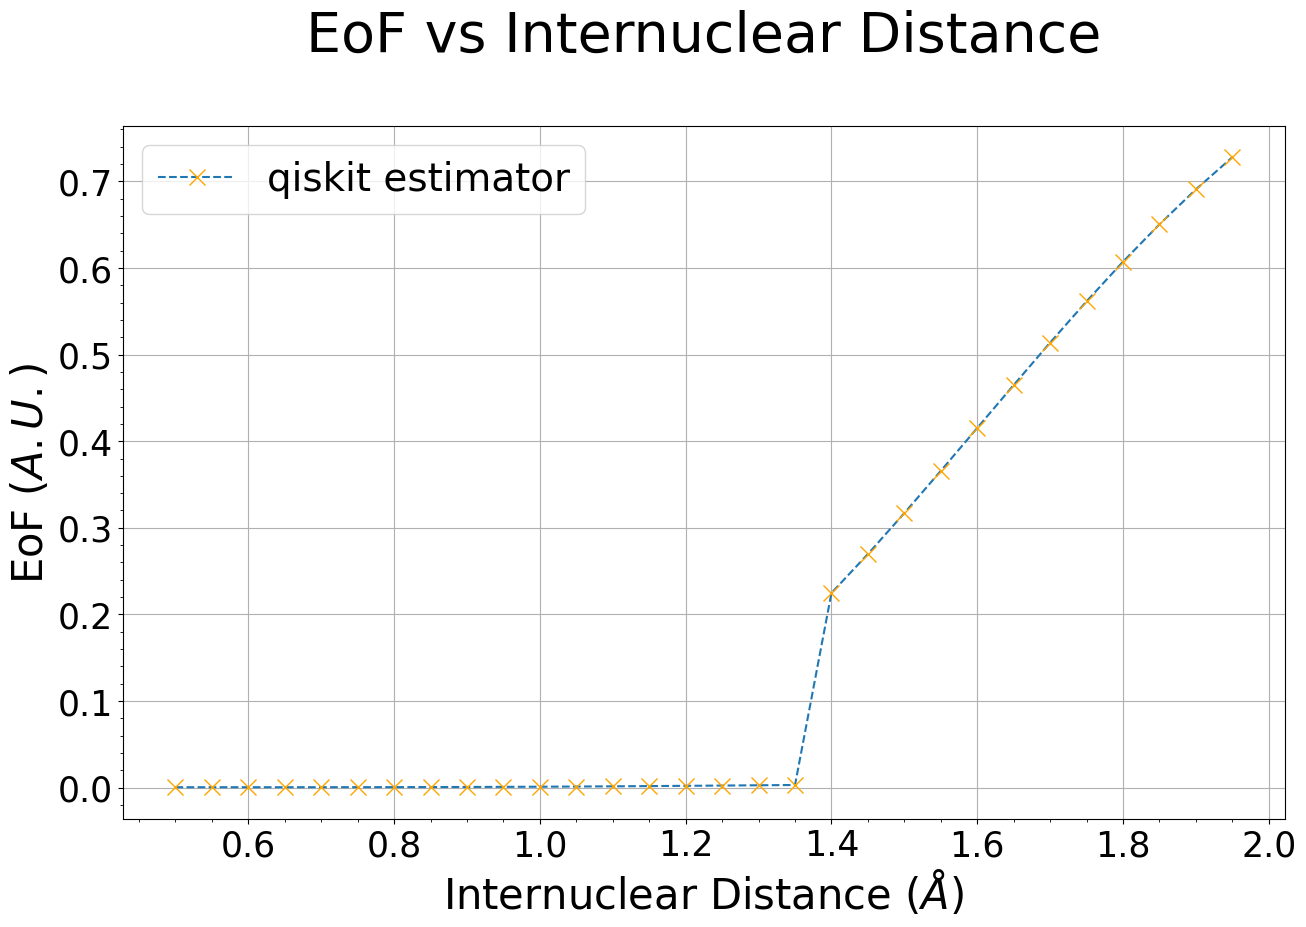

In [5]:
# Plotting the data
#distances = np.arange(0.5, 2, 0.05)


plt.figure(figsize=(15, 9))
plt.plot(distances, entgmax_HF, marker='x', linestyle='--', label= 'qiskit estimator', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 12)
plt.xlabel('Internuclear Distance ($\AA$)', fontsize= 30 )
plt.ylabel('EoF ($A.U.$)', fontsize= 30)
plt.title('EoF vs Internuclear Distance\n', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)
plt.minorticks_on()  # Enable minor ticks


plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

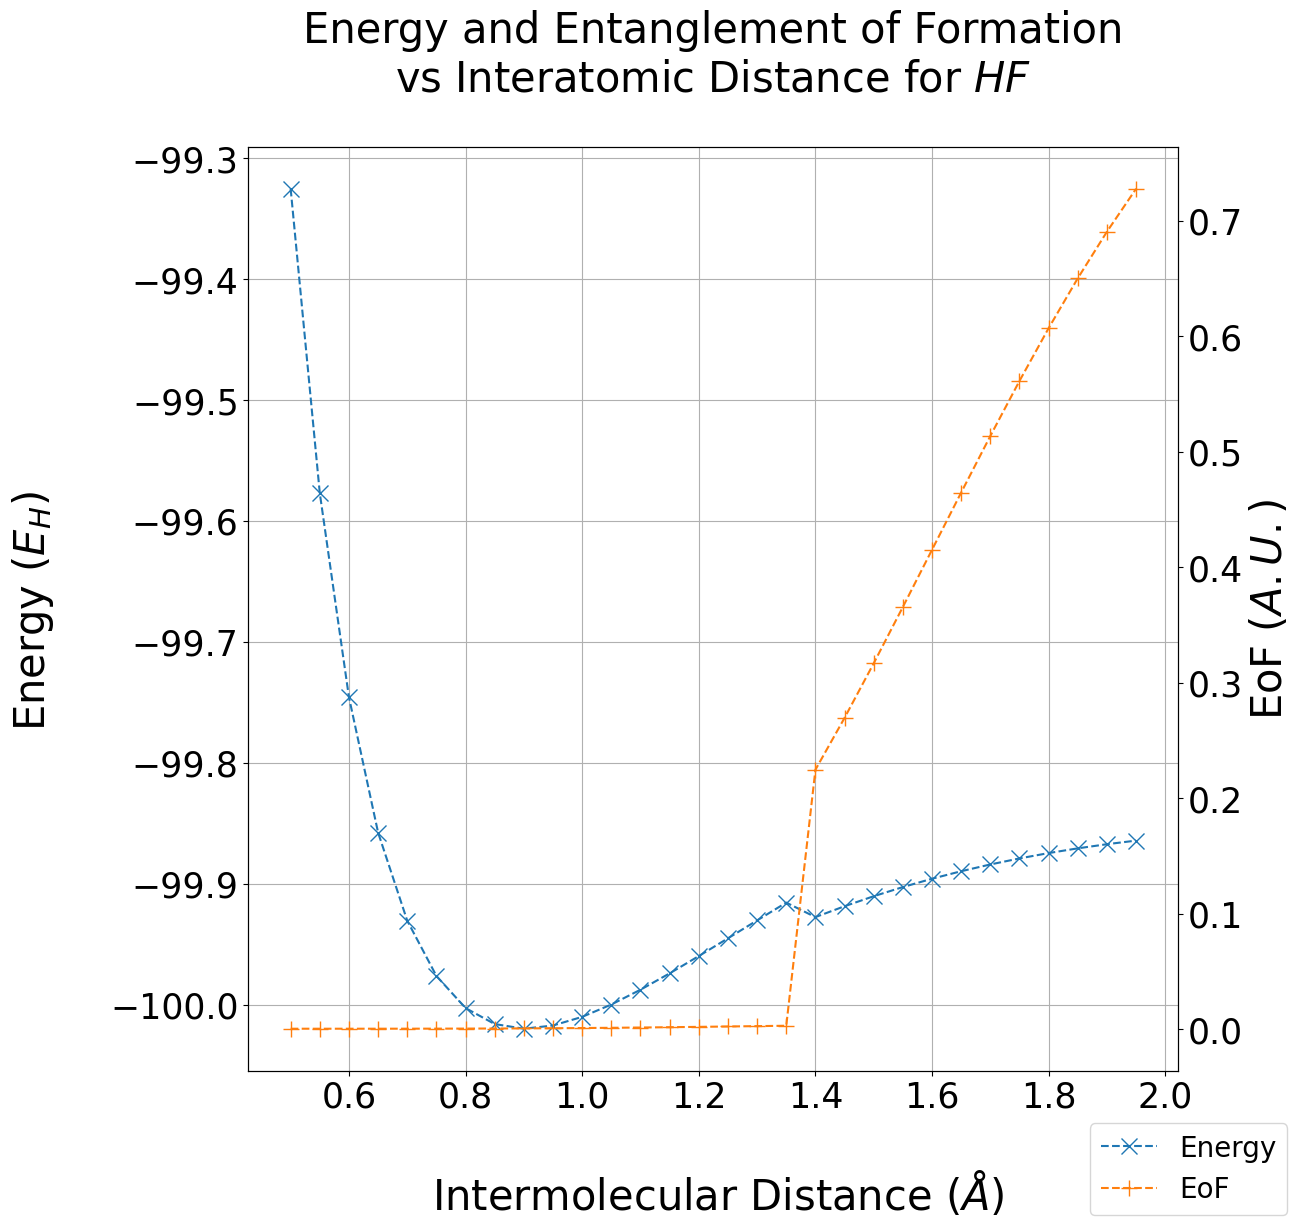

In [8]:
# Plotting the data

fig, ax1 = plt.subplots(figsize=(12, 12))


ax1.plot(distances, energies_HF, marker='x', linestyle='--', label= 'Energy', markersize= 12)

ax1.set_xlabel('\n Intermolecular Distance ($\AA$) ', fontsize= 30 )
ax1.set_ylabel('Energy ($E_H$) \n', fontsize= 30)
ax1.set_title(r'Energy and Entanglement of Formation' + '\n' + r'vs Interatomic Distance for $HF$', fontsize=30, pad=40)
ax1.grid(True)
ax1.tick_params(axis='y')
plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

ax2 = ax1.twinx()

ax2.plot(distances, entgmax_HF, marker='+', linestyle='--',label= 'EoF' , markersize= 12, color= 'tab:orange')
ax1.set_ylabel('Energy ($E_H$) \n', fontsize= 30)
ax2.tick_params(axis= 'y')
ax2.set_ylabel('EoF ($A.U.$)',  fontsize= 30)


fig.legend( loc='lower right' ,fontsize= 20)
#plt.title(f'Energy and EoF vs Internuclear Distance \n', fontsize= 40)
plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here


plt.savefig('energy_entanglement_hf.svg', format='svg', bbox_inches='tight')


#fig.tight_layout()
plt.show()

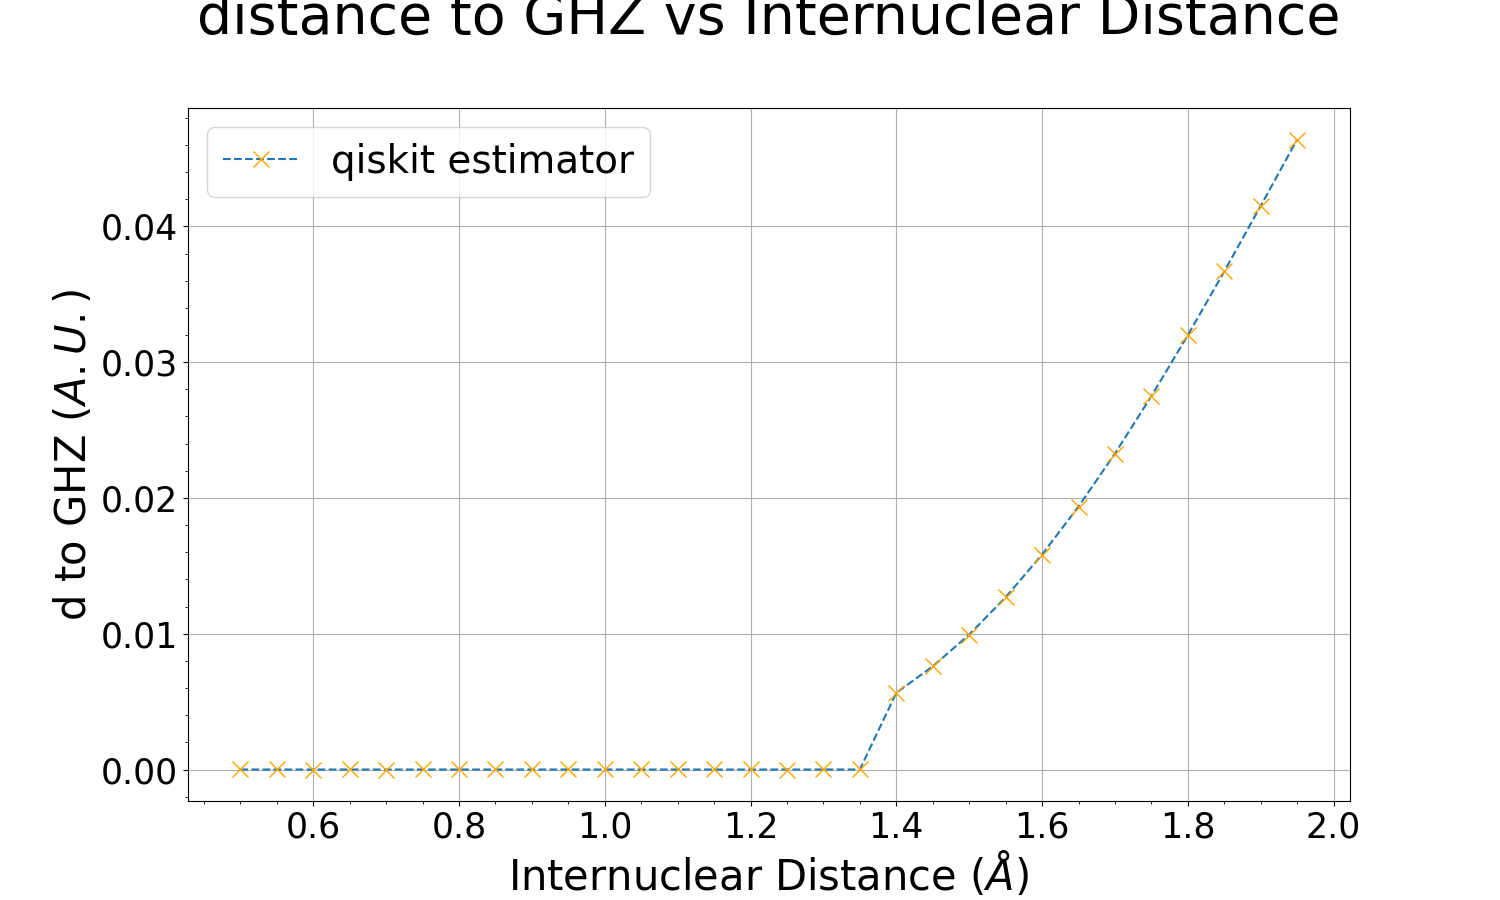

In [38]:
# Plotting the data

plt.figure(figsize=(15, 9))
plt.plot(distances, ghzmeasure_HF, marker='x', linestyle='--', label= 'qiskit estimator', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 12)
plt.xlabel('Internuclear Distance ($\AA$)', fontsize= 30 )
plt.ylabel('d to GHZ ($A.U.$)', fontsize= 30)
plt.title('distance to GHZ vs Internuclear Distance\n', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)
plt.minorticks_on()  # Enable minor ticks


plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

In [6]:
def final_stats(distances_list, energies_list):
    gs_energy = np.min(energies_list)

    gs_ener_indx = np.where(energies_list == gs_energy)[0][0]

    minimal_distance = distances_list[gs_ener_indx]

    print(f'Ground State Energy: {gs_energy} Hartree \n Distance of Equilibrium: {minimal_distance} Armstrongs')

In [14]:
final_stats(distances, energies_HF)

Ground State Energy: -100.01977226702212 Hartree 
 Distance of Equilibrium: 0.9000000000000004 Armstrongs


In [18]:
distances = np.arange(0.85, 0.95, 0.001)

estimator = Estimator()


energies_HF_fine, entgmax_HF_fine, entgtotal_HF_fine, negmax_HF_fine, negtotal_HF_fine, ghzmeasure_HF_finefine = run_calculation_for_HF_gs(swept_interval= distances, estimator= estimator)

In [7]:
final_stats(distances, energies_HF_fine)

Ground State Energy: -100.01977513245357 Hartree 
 Distance of Equilibrium: 0.902 Armstrongs


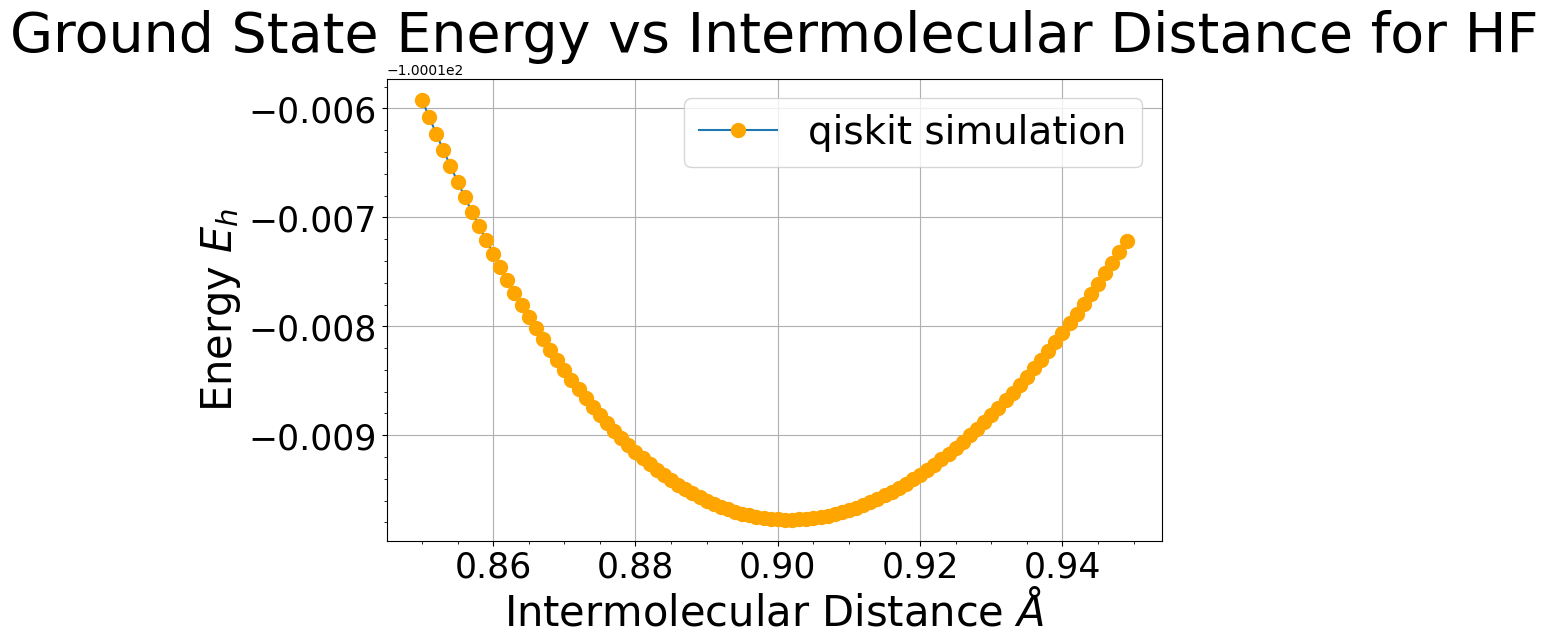

In [20]:
# Plotting the data
distances = np.arange(0.85, 0.95, 0.001)


plt.figure(figsize=(10, 6))
plt.plot(distances, energies_HF_fine, marker='o', linestyle='-', label= 'qiskit simulation', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 10)
plt.xlabel(r'Intermolecular Distance $\AA$', fontsize= 30 )
plt.ylabel(r'Energy $E_h$', fontsize= 30)
plt.title(r'Ground State Energy vs Intermolecular Distance for HF', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)
plt.minorticks_on()  # Enable minor ticks


plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

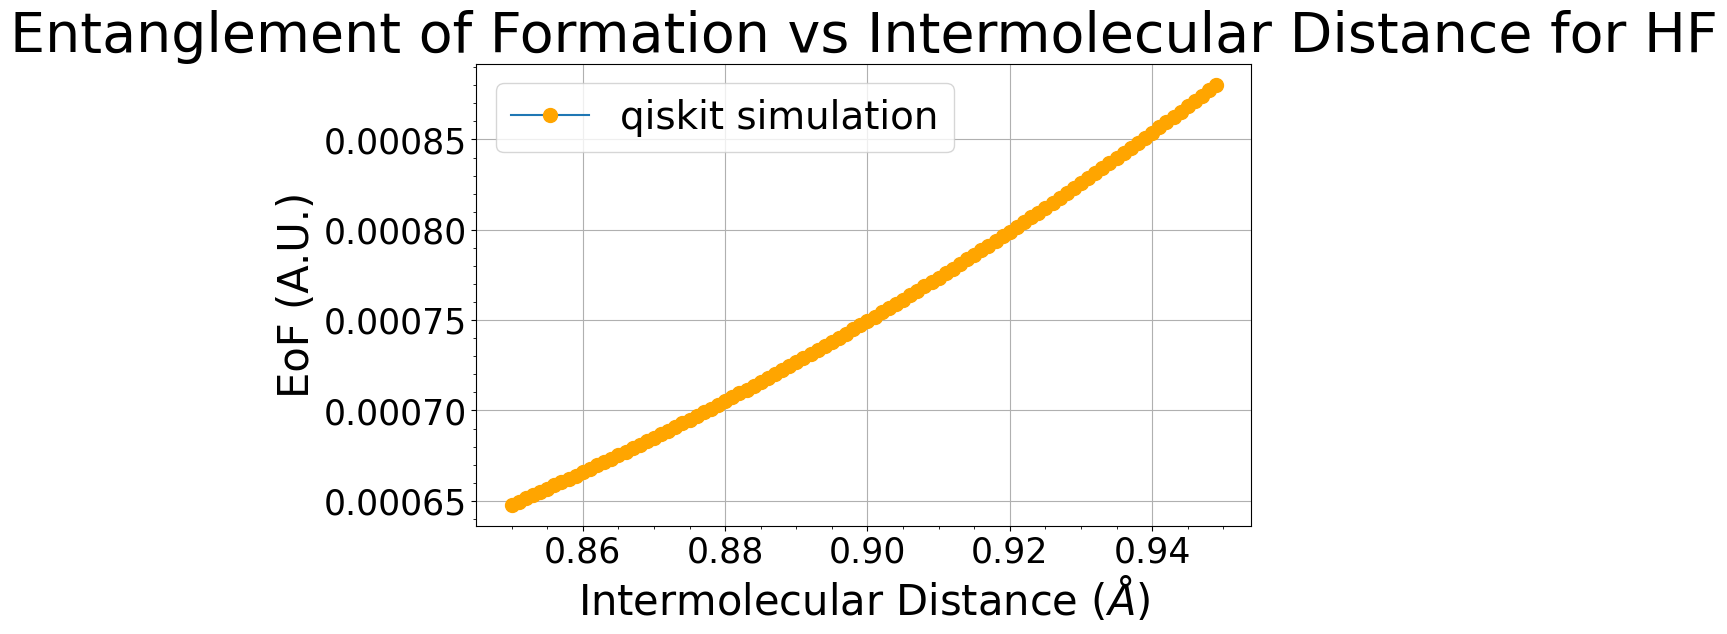

In [21]:
# Plotting the data
distances = np.arange(0.85, 0.95, 0.001)

plt.figure(figsize=(10, 6))
plt.plot(distances, entgtotal_HF_fine, marker='o', linestyle='-', label= 'qiskit simulation', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 10)
plt.xlabel(r'Intermolecular Distance ($\AA$)', fontsize= 30 )
plt.ylabel(r'EoF (A.U.)', fontsize= 30)
plt.title(r'Entanglement of Formation vs Intermolecular Distance for HF', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)
plt.minorticks_on()  # Enable minor ticks


plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

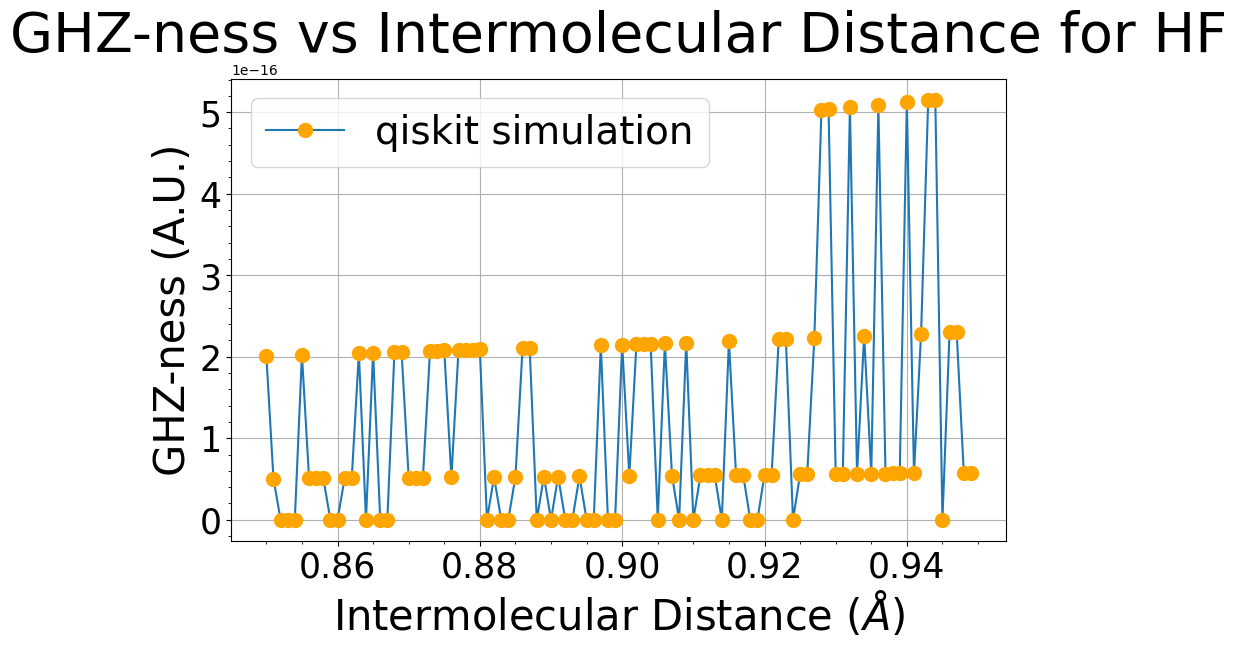

In [22]:
# Plotting the data
distances = np.arange(0.85, 0.95, 0.001)

plt.figure(figsize=(10, 6))
plt.plot(distances, ghzmeasure_HF_finefine, marker='o', linestyle='-', label= 'qiskit simulation', markeredgecolor= 'orange', markerfacecolor= 'orange' , markersize= 10)
plt.xlabel(r'Intermolecular Distance ($\AA$)', fontsize= 30 )
plt.ylabel(r'GHZ-ness (A.U.)', fontsize= 30)
plt.title(r'GHZ-ness vs Intermolecular Distance for HF', fontsize= 40)
plt.grid(True)
plt.legend(fontsize= 28)
plt.minorticks_on()  # Enable minor ticks


plt.tick_params(axis='both', which='major', labelsize=25)  # Change the label size here

plt.show()

In [26]:
energy = np.array([[-223.7800608,  -223.89886959, -223.97907878, -224.02987074, -224.0590025,
  -224.06895893, -224.06446036, -224.048406, -224.02342175, -223.99223813],
 [-223.96209929, -224.05879246, -224.12273525, -224.1939675,  -224.21386311,
  -224.18885673, -224.18221156, -224.16611325, -224.14280887, -224.11463802],
 [-224.07591424, -224.15417461, -224.24454387, -224.27399631, -224.287778,
  -224.28924532, -224.24515741, -224.22965475, -224.20832537, -224.18315847],
 [-224.14173979, -224.2528864,  -224.29191106, -224.3139496,  -224.32302038,
  -224.32195023, -224.3128365,  -224.25643572, -224.23724666, -224.21500788],
 [-224.23059395, -224.28011624, -224.31042324, -224.32660156, -224.33206072,
  -224.3291758,  -224.31968647, -224.30497513, -224.24163659, -224.22221336],
 [-224.24611566, -224.28563888, -224.30900173, -224.32058615, -224.3232938,
  -224.31911165, -224.30947474, -224.2955217,  -224.27829302, -224.21319064],
 [-224.24398099, -224.27555323, -224.29344854, -224.30147006, -224.30208621,
  -224.29696082, -224.28728773, -224.27402282, -224.2580684,  -224.24043968],
 [-224.22814111, -224.2534994, -224.26716583, -224.27245604, -224.27148546,
  -224.26566814, -224.25603303, -224.24343169, -224.22870639, -224.21280888],
 [-224.20038421, -224.22101042, -224.23150638, -224.23477659, -224.2326759,
  -224.22646641, -224.21710742, -224.20543601, -224.19228895, -224.17857228],
 [-224.16089594, -224.17789978, -224.18618935, -224.18826352, -224.18578722,
  -224.17997672, -224.17178229, -224.16204173, -224.1515141,  -224.14094346]])

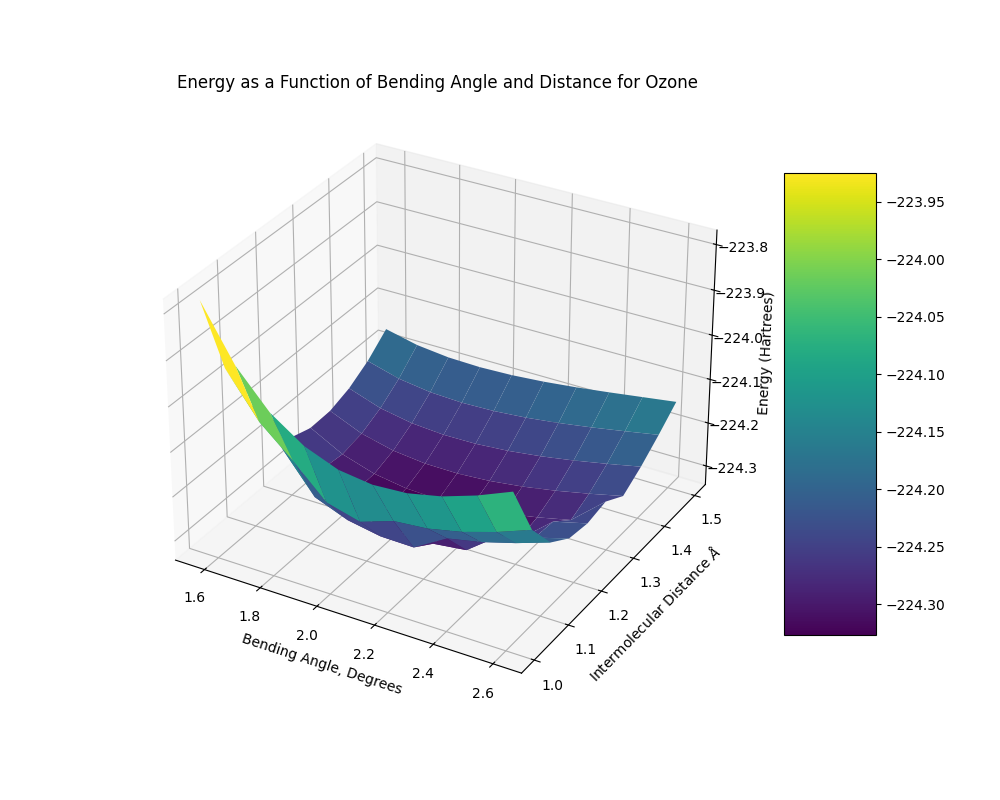

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Enable interactive mode
%matplotlib widget


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

distances = np.linspace(1, 1.5 , 10)
angles_interval = np.linspace(np.pi/2, 5 * np.pi/6, num= 10)

angles_grid, distances_grid = np.meshgrid(angles_interval, distances)

# Example energy function (replace with your actual data or function)
# This is a placeholder, replace with your actual calculation or data retrieval method


#print(energies)

# Plot surface
surf = ax.plot_surface(angles_grid, distances_grid, energy, cmap='viridis')

# Customize plot
ax.set_xlabel(r'Bending Angle, Degrees')
ax.set_ylabel(r'Intermolecular Distance $\AA$')
ax.set_zlabel('Energy (Hartrees)')
ax.set_title('Energy as a Function of Bending Angle and Distance for Ozone')

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.75, aspect=5)

plt.show()